# [Visual Word Sense Disambiguation](https://raganato.github.io/vwsd/)
Francesco Bottalico [787587]

f.bottalico15@studenti.uniba.it

# Data preparation and visualization

Download useful libraries

In [ ]:
! pip install open_clip_torch sentence_transformers nltk
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

Download training data (only needed for fine tuning)

In [ ]:
! gdown 1byX4wpe1UjyCVyYrT04sW17NnycKAK7N
! unzip -q semeval-2023-task-1-V-WSD-train-v1.zip

Download testing data

In [ ]:
! gdown 1rK7EskkEXzD59j5On-8orO5mIinQGUMW
! gdown 10vDZsY0EhzvFFR8IF-3P_2ApOF0GIMML
! mkdir test_data
! unzip -q test_images.zip -d test_data
! unzip -q test.data.v1.1.gold.zip -d test_data

Downloading...
From: https://drive.google.com/uc?id=1rK7EskkEXzD59j5On-8orO5mIinQGUMW
To: /content/test_images.zip
100% 10.4G/10.4G [09:27<00:00, 18.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=10vDZsY0EhzvFFR8IF-3P_2ApOF0GIMML
To: /content/test.data.v1.1.gold.zip
100% 36.8k/36.8k [00:00<00:00, 63.1MB/s]


Synsets retrieval

In [ ]:
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords

def _get_synsets(word, wn_pos):
  variants = [word,
              word.replace('-', '_'),
              word.replace("'", " ").strip(),
              ' '.join([x for x in word.split(' ') if x not in stopwords.words('english')]).strip(),
              ' '.join([x for x in word.replace("'", " ").split(' ') if x not in stopwords.words('english')]).strip()]
  for w in variants:
    ss = wn.synsets(w.replace(' ', '_'), wn_pos)
    if len(ss) > 0:
      return ss
  return ss

def _convert_postag(postag):
  if postag.find('VB') != -1:
    return wn.VERB
  return wn.NOUN

def get_synsets(word, postag=None):
  wn_pos_all = [wn.NOUN, wn.VERB, wn.ADJ]
  if postag:
    wn_pos_all.insert(0, wn_pos_all.pop(wn_pos_all.index(_convert_postag(postag))))
  for wn_pos in wn_pos_all:
    ss = _get_synsets(word, wn_pos)
    if len(ss) > 0:
      return ss
  return ss

Print useful information about training and test data - **do not run this cell**

TRAIN DATA
Number of training samples: 12869
Number of unique ambiguous words: 12527
Minimum context lenght: 2
Maximum context lenght: 2
TEST DATA
Number of training samples: 463
Number of unique ambiguous words: 259
Minimum context lenght: 2
Maximum context lenght: 4


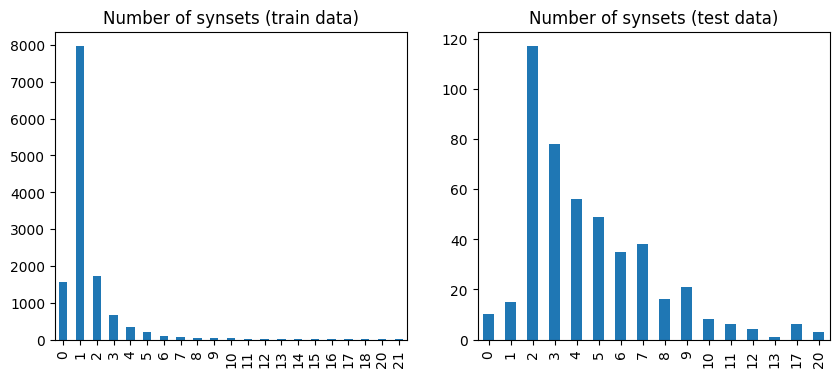

In [ ]:
import pandas
import matplotlib.pyplot as plt

def data_info(path, ax):
  data = pandas.read_csv(path, sep='\t', header=None)
  print(f'Number of training samples: {len(data)}')
  print(f'Number of unique ambiguous words: {len(data.iloc[:,0].unique())}')
  print(f'Minimum context lenght: {data.iloc[:,1].map(lambda x : x.count(" ") + 1).min()}')
  print(f'Maximum context lenght: {data.iloc[:,1].map(lambda x : x.count(" ") + 1).max()}')
  data.iloc[:,0].map(lambda x : len(get_synsets(str(x)))).value_counts().sort_index().plot(kind='bar', ax=ax)

fig, axs = plt.subplots(ncols=2, figsize=(10,4))
print('TRAIN DATA')
data_info('semeval-2023-task-1-V-WSD-train-v1/train_v1/train.data.v1.txt', axs[0])
axs[0].set_title('Number of synsets (train data)')
print('TEST DATA')
axs[1].set_title('Number of synsets (test data)')
data_info('test_data/en.test.data.v1.1.txt', axs[1])
plt.show()

Class to manage the datasets

In [ ]:
import torch
import os
import unicodedata
import numpy as np
from PIL import Image

class VWSDDataset(torch.utils.data.Dataset):
  def __init__(self, img_dir, label_dir, preproc=lambda x: x, cache=True, device='cpu'):
    self.img_dir = img_dir
    self.cache = cache
    self.img_dir_cache = os.path.join(img_dir, '.cache')
    self.preproc = preproc
    self.device = device
    self.word = []
    self.context = []
    self.images = []
    self.true = []
    if not os.path.exists(self.img_dir_cache) and self.cache:
      os.mkdir(self.img_dir_cache)
    for f in os.listdir(label_dir):
      if 'data' not in f or (not f.startswith('en') and not f.startswith('train')):
        continue
      with open(os.path.join(label_dir, f)) as f1, open(os.path.join(label_dir, f.replace('data', 'gold'))) as f2:
        for l1, l2 in zip(f1, f2):
          entry = l1.split('\t')
          imgs = [x.strip() for x in entry[2:]]
          pos = imgs.index(l2.strip())
          self.word.append(entry[0])
          self.context.append(entry[1])
          self.images.append(imgs)
          self.true.append(pos)
  def __len__(self):
    return len(self.word)
  def __getitem__(self, i):
    if type(i) is slice:
      images = []
      for j in range(0 if i.start is None else i.start, i.stop):
        images.append(torch.stack([self.preproc(Image.open(os.path.join(self.img_dir, img))) for img in self.images[j]], dim=0))
      images = torch.cat(images)
    else:
      #images = torch.stack([self.preproc(Image.open(os.path.join(self.img_dir, img))) for img in self.images[i]], dim=0)
      images = []
      for img in self.images[i]:
        img_cache = os.path.join(self.img_dir_cache, img)
        if self.cache and os.path.isfile(img_cache):
          images.append(torch.load(img_cache))
        else:
          image = self.preproc(Image.open(os.path.join(self.img_dir, img)))
          images.append(image)
          if self.cache:
            torch.save(image, img_cache)
      images = torch.stack(images, dim=0).to(self.device) if self.cache else images
    return self.word[i], self.context[i], images, self.true[i]

## Disambiguator
Implemented algorithms:
- MPNet encoder
- Wordnet tree similarity
- Lesk algorithm

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import PorterStemmer
from sentence_transformers import SentenceTransformer
import sentence_transformers.util as util

class Disambiguator():
  def __init__(self, algorithm='mpnet', postag=False, device='cpu'):
    if algorithm not in ['mpnet', 'wordnet', 'lesk']:
      return Exception('Not a valid algorithm.')
    if algorithm == 'mpnet':
      self.model = SentenceTransformer('all-mpnet-base-v2', device=device)
    self.algorithm = algorithm
    self.postag = postag
  def _text_preproc(self, text, tokenize=True):
    stemmer = PorterStemmer()
    tokens = word_tokenize(text) if tokenize else text
    bow = set([stemmer.stem(t.lower()) for t in tokens if t not in stopwords.words('english') and t.isalpha()])
    return bow
  def _get_tags(self, word, context):
    tags = pos_tag(context.split(' '))
    context_tag = []
    for i in tags:
      if i[0] == word:
        word_tag = i[1]
      elif i[0] not in stopwords.words('english'):
        context_tag.append(i[1])
    context_tag = context_tag[0] if len(context_tag) == 1 else wn.NOUN
    return word_tag, context_tag
  def mpnet(self, word, context, postag=False):
    senses = []
    for w, c in zip(word, context):
      if postag:
        w_tag, c_tag = self._get_tags(w, c)
      else:
        w_tag, c_tag = None, None
      w_def_all = [x.definition() for x in get_synsets(w, w_tag)]
      c_def_all = [x.definition() for x in get_synsets(c.replace(w, '').strip(), c_tag)]
      if len(w_def_all) == 1:
        senses.append(w_def_all[0])
        continue
      if len(w_def_all) == 0 or len(c_def_all) == 0:
        senses.append(f'intended as {c.replace(w, "").strip()}')
        continue
      w_def_emb = self.model.encode(w_def_all, convert_to_tensor=True)
      c_def_emb = self.model.encode(c_def_all, convert_to_tensor=True)
      sim = util.dot_score(w_def_emb, c_def_emb)
      senses.append(w_def_all[sim.argmax() // len(c_def_all)])
    return senses
  def wordnet(self, word, context, postag=False):
    senses = []
    for w, c in zip(word, context):
      if postag:
        w_tag, c_tag = self._get_tags(w, c)
      else:
        w_tag, c_tag = None, None
      max_sim = 0
      w_ss_all = get_synsets(w, w_tag)
      c_ss_all = get_synsets(c.replace(w, '').strip(), c_tag)
      if len(w_ss_all) == 1:
        senses.append(w_ss_all[0].definition())
        continue
      if len(w_ss_all) == 0 or len(c_ss_all) == 0:
        senses.append(f'intended as {c.replace(w, "").strip()}')
        continue
      for w_ss in w_ss_all:
        for c_ss in c_ss_all:
          sim = w_ss.path_similarity(c_ss)
          if sim > max_sim:
            max_sim = sim
            sense = w_ss.definition()
      senses.append(sense)
    return senses
  def lesk(self, word, context, postag=False):
    senses = []
    for w, c in zip(word, context):
      if postag:
        w_tag, c_tag = self._get_tags(w, c)
      else:
        w_tag, c_tag = None, None
      max_sim = 0
      w_ss_all = get_synsets(w, w_tag)
      c_ss_all = get_synsets(c.replace(w, '').strip(), c_tag)
      if len(w_ss_all) == 1:
        senses.append(w_ss_all[0].definition())
        continue
      if len(w_ss_all) == 0 or len(c_ss_all) == 0:
        senses.append(f'intended as {c.replace(w, "").strip()}')
        continue
      for w_ss in w_ss_all:
        w_ss_bow = self._text_preproc(w_ss.definition())
        w_ss_bow = w_ss_bow.union(self._text_preproc(w_ss.lemma_names(), tokenize=False))
        for c_ss in c_ss_all:
          c_ss_bow = self._text_preproc(c_ss.definition())
          c_ss_bow = c_ss_bow.union(self._text_preproc(c_ss.lemma_names(), tokenize=False))
          sim = len(w_ss_bow.intersection(c_ss_bow))
          if sim > max_sim:
            max_sim = sim
            sense = w_ss.definition()
      if max_sim == 0:
        sense = f'intended as {c.replace(w, "").strip()}'
      senses.append(sense)
    return senses
  def __call__(self, word, context):
    if type(word) is not list and type(word) is not tuple:
      word = [word]
    if type(context) is not list and type(word) is not tuple:
      context = [context]
    senses = getattr(self, self.algorithm)(word, context, self.postag)
    if len(senses) == 1:
      return senses[0]
    return senses

# Data samples visualizator
An interactive way to visualize the data by choosing the data sample through the variable `sample`.
- **Ambiguous word** is the target word
- **Context** is the context given to disambiguate the word
- **Expanded context** is the information extracted from wordnet by the disambiguation algorithm (mpnet by default)
- The 10 candidate images are shown, the correct one is the one in green

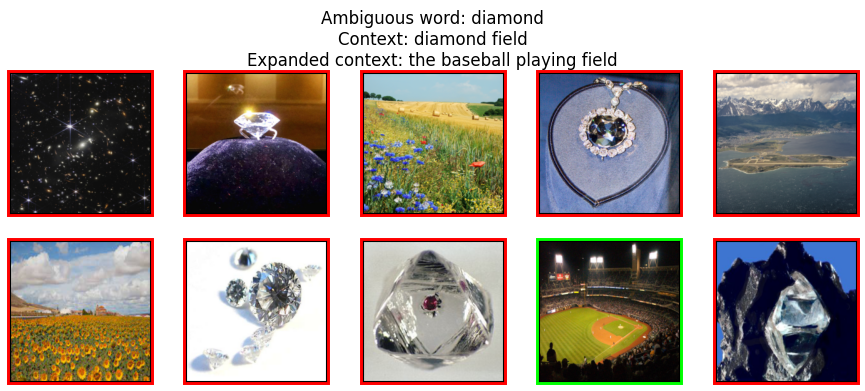

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as VF

dis = Disambiguator('mpnet')
data = VWSDDataset('test_data/test_images/', 'test_data/', cache=False)
# 'diamond' word example at index 131 and 462
sample = data[-1]
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(11,4))
for i, ax in enumerate(axs.flatten()):
  if i == 2:
    ax.set_title(f'Ambiguous word: {sample[0]}\nContext: {sample[1]}\nExpanded context: {dis(sample[0], sample[1])}')
  ax.imshow(VF.resize(sample[2][i], (224,224)))
  ax.patch.set_edgecolor('lime') if i == sample[3] else ax.patch.set_edgecolor('red')
  ax.patch.set_linewidth(5)
  ax.xaxis.set_visible(False)
  ax.yaxis.set_visible(False)
plt.show()

# Fine tuning
Run this only to fine tune the Resnet50 CLIP model. Gradient accumulation is used in order to simulate larger batch sizes while having a limited GPU memory.

In [ ]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.nn import NLLLoss
import open_clip

BATCH_SIZE = 8
GRAD_ACC = 8
EPOCHS = 2
LEARNING_RATE = 2e-5

dev = 'cuda' if torch.cuda.is_available() else 'cpu'
disambiguator = Disambiguator('mpnet', postag=False, device=dev)
tokenizer = open_clip.get_tokenizer('RN50')
model, preprocess, _ = open_clip.create_model_and_transforms('RN50', 'openai', device=dev)
data = VWSDDataset('semeval-2023-task-1-V-WSD-train-v1/train_v1/train_images_v1/', 'semeval-2023-task-1-V-WSD-train-v1/train_v1/', preprocess, device=dev)
opt = AdamW([{'params': model.text_projection},
             {'params': model.visual.attnpool.parameters()}],
            lr=LEARNING_RATE)
loss = NLLLoss()
model.train()
for epoch in range(EPOCHS):
  i = 0
  for word, context, images, true in DataLoader(data, batch_size=BATCH_SIZE, shuffle=True):
    text = tokenizer([f'This is {c}, {exp}.' for c, exp in zip(context, disambiguator(word, context))]).to(dev)
    text_emb = model.encode_text(text, normalize=True)
    imgs_emb = model.encode_image(images.flatten(end_dim=1), normalize=True)

    scores = (100.0 * torch.einsum('ij,ikj->ik', text_emb, imgs_emb.view(text_emb.size(0), 10, -1))).log_softmax(-1)
    l = loss(scores, true.to(dev)) / GRAD_ACC
    l.backward()
    i += scores.size(0)
    print(f'[epoch {epoch} | {i}/{len(data)}] loss: {l}')
    if i % (BATCH_SIZE * GRAD_ACC) == 0 or scores.size(0) < BATCH_SIZE:
      print('Optimization step')
      opt.step()
      opt.zero_grad()
print('Training finished')
torch.save(model.state_dict(), 'finetuned.pt')

# Test evaluation
Run the evaluation on the test set. The parameters to tune are the following:
- `BATCH_SIZE`
- `DIS_ALG`: algorithm used to disambiguate the target word (*mpnet*, *wordnet* or *lesk*)
- `MODEL`: The CLIP variant to use (**RN50**, **ViT-B-16** or **ViT-L-14**, ordered from the least to the most powerful)
- `CHECKPOINT`: Path to a custom set of weights for the model

In [ ]:
import torch
from torch.utils.data import DataLoader
import open_clip
dev = 'cuda' if torch.cuda.is_available() else 'cpu'
MODEL_LIST = {'RN50': 'openai',
              'ViT-B-16': 'laion2b_s34b_b88k',
              'ViT-L-14': 'datacomp_xl_s13b_b90k'}

def compute_metrics(scores, pos):
  sorted_score = scores.argsort(descending=True)
  ranks = (sorted_score == pos.unsqueeze(0).T).nonzero(as_tuple=True)[1] + 1
  h1 = (ranks == 1).nonzero().flatten().size(0) / scores.size(0)
  h3 = (ranks <= 3).nonzero().flatten().size(0) / scores.size(0)

  return {'mrr': (1 / ranks).mean().item(), 'hits1': h1, 'hits3': h3}

BATCH_SIZE = 32
DIS_ALG = 'mpnet'
MODEL = 'RN50'
# To use a custom set of weights (must be compatible with the selected model)
CHECKPOINT = None

with torch.no_grad():
  disambiguator = Disambiguator(DIS_ALG, postag=False, device=dev)
  tokenizer = open_clip.get_tokenizer(MODEL)
  model, _, preprocess = open_clip.create_model_and_transforms(MODEL, MODEL_LIST[MODEL], device=dev)

  if CHECKPOINT:
    model.load_state_dict(torch.load(CHECKPOINT))

  data = VWSDDataset('test_data/test_images/', 'test_data/', preprocess, device=dev)
  all_scores = torch.empty((0,10))
  all_pos = torch.empty((0,))
  i = 0
  for word, context, images, true in DataLoader(data, batch_size=BATCH_SIZE):
    text = tokenizer([f'This is {c}, {exp}.' for c, exp in zip(context, disambiguator(word, context))]).to(dev)
    text_emb = model.encode_text(text, normalize=True)
    imgs_emb = model.encode_image(images.flatten(end_dim=1), normalize=True)

    scores = (100.0 * torch.einsum('ij,ikj->ik', text_emb, imgs_emb.view(text_emb.size(0), 10, -1))).softmax(-1)
    all_scores = torch.cat((all_scores, scores.cpu()))
    all_pos = torch.cat((all_pos, true))
    i += scores.size(0)
    print(f'{i}/{len(data)}')
  print(compute_metrics(all_scores, all_pos))

# CLIP interactive demo
An interactive demo of the CLIP model. In order to use it just edit the parameters `IMG2TEXT`, `IMAGES`, `TEXT`, `MODEL`:
- `IMG2TEXT`: Set this parameter to *True* if you want to associate a text label to each given image, set it to *False* if you wanto to associate an image to each given text.
In the first case the sum of the probability matrix columns will be 1, in the latter the sum of the rows will be 1.
- `IMAGES`: List of the images to load, the content of this list must be the paths of the images.
- `TEXT`: List of all the text labels to use.
- `MODEL`: The CLIP variant to use (**RN50**, **ViT-B-16** or **ViT-L-14**, ordered from the least to the most powerful)

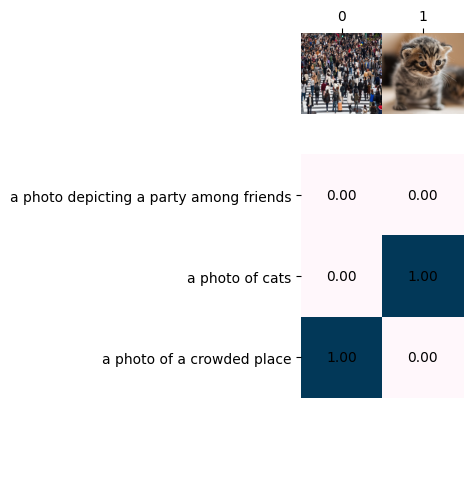

In [ ]:
import torch
import open_clip
import matplotlib.pyplot as plt
from PIL import Image
dev = 'cuda' if torch.cuda.is_available() else 'cpu'
MODEL_LIST = {'RN50': 'openai',
              'ViT-B-16': 'laion2b_s34b_b88k',
              'ViT-L-14': 'datacomp_xl_s13b_b90k'}

# True if you want to find the correct text given an image,
# False if you want to find the correct image given a text
IMG2TEXT = True
IMAGES = ['crowd.jpeg', 'cat.jpg']
TEXT = ['a photo depicting a party among friends', 'a photo of cats', 'a photo of a crowded place']
MODEL = 'RN50'

def plot(similarity, texts, images, gold_image_index=None):
    assert similarity.shape[0] == len(texts) and similarity.shape[1] == len(images), \
        f"{similarity.shape} != {(len(images), len(texts))}"
    plt.figure(figsize=(11, 5))
    plt.imshow(similarity, vmin=0.1, vmax=0.3, cmap=plt.cm.PuBu)
    plt.yticks(range(len(texts)), texts, fontsize=10)
    if gold_image_index is not None:
        plt.xticks(range(len(images)), ['' if i != gold_image_index else 'True Image' for i in range(len(images))],
                   fontsize=10)
    else:
        plt.xticks(range(len(images)), fontsize=10)
    for i, image in enumerate(images):
        plt.imshow(Image.open(image).convert("RGB"), extent=(i - 0.5, i + 0.5, -2.0, -1), origin="lower")
    for x in range(len(images)):
        for y in range(len(texts)):
            plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=10)
    for side in ["left", "top", "right", "bottom"]:
        plt.gca().spines[side].set_visible(False)
    plt.gca().xaxis.tick_top()
    plt.xlim([-0.5, len(images) - 0.5])
    plt.ylim([len(texts) + 0.5, -2])
    plt.tight_layout()

with torch.no_grad():
  tokenizer = open_clip.get_tokenizer(MODEL)
  model, _, preprocess = open_clip.create_model_and_transforms(MODEL, MODEL_LIST[MODEL], device=dev)

  images = torch.stack([preprocess(Image.open(img)) for img in IMAGES], dim=0).to(dev)
  text = tokenizer(TEXT).to(dev)
  imgs_emb = model.encode_image(images, normalize=True)
  text_emb = model.encode_text(text, normalize=True)
  scores = (100.0 * text_emb @ imgs_emb.T).softmax(0 if IMG2TEXT else 1)
plot(scores, TEXT, IMAGES)